## Model-Based 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# load binned data
binned_df = pd.read_csv('Data/binned_df.csv')
binned_df.head()

,Unnamed: 0,MAP,diastolic_bp,systolic_bp,urine,ALT,AST,p_f_ratio,lactic_acid,serum_creatinine,GCS_total,fluid_boluses,vasopressors,PatientID,Timepoints
0,0,3,1,2,2,0,0,0,0,0,3,0,0,0,0
1,1,2,1,2,2,0,0,1,0,0,3,0,0,0,1
2,2,3,1,2,2,0,0,0,0,0,3,0,0,0,2
3,3,0,1,1,2,0,0,1,0,0,3,0,0,0,3
4,4,2,2,1,2,1,0,0,0,0,3,0,0,0,4


In [3]:
# state and action columns
binned_state_columns = ['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total']
action_columns = ['fluid_boluses', 'vasopressors']

def create_transitions(df):
    X = []
    y = []
    patients = df['PatientID'].unique()

    for patient in patients:
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        for i in range(len(patient_records) - 1):
            current_state = patient_records.iloc[i][binned_state_columns]
            next_state = patient_records.iloc[i + 1][binned_state_columns]
            action = patient_records.iloc[i][action_columns]
            X.append(np.concatenate([current_state, action]))
            y.append(next_state)
    return pd.DataFrame(X, columns=binned_state_columns + action_columns), pd.DataFrame(y, columns=binned_state_columns)

In [4]:
# create transitions (model-based --> mb)
X_mb, y_mb = create_transitions(binned_df)

In [5]:
#use K nearest neighbours to calculate next state prediction (function approximation for transitions)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_mb_train, X_mb_test, y_mb_train, y_mb_test = train_test_split(X_mb, y_mb, test_size=0.2, random_state=42)
knn_models = {col: KNeighborsClassifier(n_neighbors=20) for col in binned_state_columns}

for col in binned_state_columns:
    knn_models[col].fit(X_mb_train, y_mb_train[col])

#evaluate accuracy
predictions = pd.DataFrame()
for col in binned_state_columns:
    predictions[col] = knn_models[col].predict(X_mb_test)
    accuracy = accuracy_score(y_mb_test[col], predictions[col])
    print(f"Accuracy for predicting {col}: {accuracy:.2f}")

Accuracy for predicting MAP: 0.50
Accuracy for predicting diastolic_bp: 0.69
Accuracy for predicting systolic_bp: 0.68
Accuracy for predicting urine: 0.71
Accuracy for predicting ALT: 0.81
Accuracy for predicting AST: 0.80
Accuracy for predicting lactic_acid: 0.93
Accuracy for predicting serum_creatinine: 0.85
Accuracy for predicting p_f_ratio: 0.63
Accuracy for predicting GCS_total: 0.89


In [6]:
# reward function for binned values
def get_unbinned_MAP(binned_MAP):
    """
    Convert binned MAP values to representative unbinned values
    MAP bins: 0: <55, 1: 55-60, 2: 60-65, 3: >65
    Using conservative (lower) values for each bin
    """
    MAP_values = {
        0: 50,  # For <55, use 50 as representative
        1: 55,  # For 55-60, use 55
        2: 60,  # For 60-65, use 60
        3: 65   # For >65, use 65
    }
    return MAP_values[binned_MAP]

def get_unbinned_urine(binned_urine):
    """
    Convert binned urine values to representative unbinned values
    Urine bins: 0: <30, 1: 30-50, 2: >50
    Using conservative (lower) values for each bin
    """
    urine_values = {
        0: 25,  # For <30, use 25 as representative
        1: 30,  # For 30-50, use 30
        2: 50   # For >50, use 50
    }
    return urine_values[binned_urine]

def calculate_reward(MAP, urine):
    """Calculate reward based on unbinned MAP and urine values"""
    # First check the special case for urine and MAP
    if urine > 30 and MAP > 55:
        return 0

    # Otherwise, calculate reward based on MAP piecewise function
    if MAP > 65:
        return 0
    elif 60 < MAP <= 65:
        return (-0.05 * (65 - MAP)) / 5
    elif 55 < MAP <= 60:
        return (-0.1 * (60 - MAP)) / 5 - 0.05
    else:  # MAP <= 55
        return (-0.85 * (55 - MAP)) / 15 - 0.15

def calculate_reward_from_binned(binned_MAP, binned_urine):
    """Calculate reward using binned values by converting to unbinned first"""
    unbinned_MAP = get_unbinned_MAP(binned_MAP)
    unbinned_urine = get_unbinned_urine(binned_urine)
    return calculate_reward(unbinned_MAP, unbinned_urine)

In [7]:
# get reward
binned_df["reward"] = binned_df.apply(lambda row: calculate_reward_from_binned(row["MAP"], row["urine"]), axis=1)

# get action
binned_df['action_number'] = 4 * binned_df['fluid_boluses'] + binned_df['vasopressors']

In [8]:
#train test split
seed = 42
np.random.seed(seed)
train_ratio = 0.8
num_patients = binned_df['PatientID'].nunique()
num_train_samples = int(num_patients * train_ratio)

train_ids = np.random.choice(num_patients, num_train_samples, replace=False)
train_mb_df = binned_df[binned_df["PatientID"].isin(train_ids)].reset_index(drop=True)
test_mb_df = binned_df[~binned_df["PatientID"].isin(train_ids)].reset_index(drop=True)

print(f'Train Data: {train_mb_df.shape}')
print(f'Test Data: {test_mb_df.shape}')

Train Data: (150144, 17)
Test Data: (37536, 17)


In [9]:
import random
from tqdm import tqdm

# get dictionary
train_state_dict = {tuple(row): idx for idx, row in enumerate(train_mb_df[binned_state_columns].drop_duplicates().values)}

# helper functions
def get_state_index(row, state_columns=binned_state_columns):
    return train_state_dict[tuple(row[state_columns])]

def find_closest_index(input_tuple, train_state_dict=train_state_dict):
    closest_index = None
    min_distance = float("inf")

    # Convert input tuple to numeric array
    input_array = np.array(input_tuple).astype(float)

    for state_tuple, index in train_state_dict.items():
        # Convert state tuple to numeric array
        state_array = np.array(state_tuple).astype(float)

        # Calculate Euclidean distance
        distance = np.linalg.norm(state_array - input_array)

        if distance < min_distance:
            min_distance = distance
            closest_index = index

    return closest_index

state_size = len(train_state_dict)
action_size = 16

# return state action pair
def return_state_action_df(row, fluid, vaso):
    state_action = {}
    for col in binned_state_columns:
        state_action[col] = row[col].item()

    state_action["fluid_boluses"] = fluid
    state_action["vasopressors"] = vaso
    return pd.DataFrame([state_action])

def clinician_cumulative_reward(df, gamma=0.99):
    patients = df["PatientID"].unique()

    total_cumulative_reward = 0
    rewards = []

    for patient in patients:
        patient_reward = 0
        patient_records = df[df['PatientID']==patient].reset_index(drop=True)
        for i in range(len(patient_records) - 1): # 0 to 47 (exclusive of 47)
            reward = patient_records.iloc[i]["reward"].item()
            # times gamma (for patient trajectory)
            patient_reward += (gamma ** i) * reward

        rewards.append(patient_reward)
        total_cumulative_reward += patient_reward

    return total_cumulative_reward, rewards

In [ ]:
def precompute_transitions(train_df):
    """
    Precompute all valid transitions from the training data.

    Args:
        train_df: DataFrame containing training data

    Returns:
        dict: Dictionary of patient transitions
        list: List of observed state-action pairs
    """
    print("Precomputing transitions...")

    # Initialize containers
    patient_transitions = {}
    observed_pairs = set()

    # Process each patient
    for patient_id in tqdm(train_df['PatientID'].unique()):
        patient_data = train_df[train_df['PatientID'] == patient_id].sort_values('Timepoints')
        patient_transitions[patient_id] = []

        for i in range(len(patient_data) - 1):
            current_row = patient_data.iloc[i]
            next_row = patient_data.iloc[i + 1]

            if current_row['Timepoints'] < 47:
                # Get state indices and action
                current_state = get_state_index(current_row)
                next_state = get_state_index(next_row)
                action = int(current_row['action_number'])

                # Store transition
                patient_transitions[patient_id].append({
                    'state': current_state,
                    'action': action,
                    'reward': current_row['reward'],
                    'next_state': next_state
                })

                # Add to observed pairs
                observed_pairs.add((current_state, action))

    print(f"Processed {len(patient_transitions)} patients")
    print(f"Found {len(observed_pairs)} unique state-action pairs")

    return patient_transitions, list(observed_pairs)

In [13]:
class DynaQAgent:
    def __init__(self, state_size, action_size, knn_models, gamma=0.99, alpha=0.1, planning_steps=10):
        """
        Initialize DynaQ Agent
        
        Args:
            state_size: Number of possible states
            action_size: Number of possible actions
            knn_models: Dictionary of KNN models for each state variable
            gamma: Discount factor
            alpha: Learning rate
            planning_steps: Number of planning steps per real experience
        """
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.planning_steps = planning_steps
        
        # Initialize Q-table with NaN
        self.q_table = np.full((state_size, action_size), np.nan, dtype=np.float32)
        
        # Store KNN models
        self.knn_models = knn_models
        
        # Initialize caches
        self.state_row_cache = {}  # Cache for state representations
        self.prediction_cache = {}  # Cache for state predictions
        self.cache_size = 10000
        
        # Initialize RNG for efficient sampling
        self.rng = np.random.default_rng()

    def initialize_q_values(self, train_df):
        """Initialize Q-values and state cache from training data"""
        print("Initializing Q-values and state cache...")
        
        # Get minimum reward for initialization
        min_reward = np.min(train_df["reward"])
        
        # Efficiently cache unique states
        unique_states = train_df[binned_state_columns].drop_duplicates()
        for _, row in tqdm(unique_states.iterrows(), desc="Caching states"):
            state_idx = get_state_index(row)
            self.state_row_cache[state_idx] = pd.Series(
                row[binned_state_columns].values, 
                index=binned_state_columns
            )
        
        # Initialize Q-values for observed state-action pairs
        states = train_df.apply(lambda row: get_state_index(row), axis=1).values
        actions = train_df['action_number'].astype(int).values
        
        for state, action in tqdm(zip(states, actions), desc="Initializing Q-values"):
            self.q_table[state, action] = min_reward
        
        print(f"Cached {len(self.state_row_cache)} unique states")
        print(f"Initialized Q-values for {np.sum(~np.isnan(self.q_table))} state-action pairs")

    def predict_next_state(self, state_row, action):
        """Predict next state using cached predictions when possible"""
        cache_key = (tuple(state_row), action)
        
        # Return cached prediction if available
        if cache_key in self.prediction_cache:
            return self.prediction_cache[cache_key]
            
        # Manage cache size
        if len(self.prediction_cache) >= self.cache_size:
            # Remove oldest 10% of entries
            remove_keys = list(self.prediction_cache.keys())[:self.cache_size//10]
            for k in remove_keys:
                self.prediction_cache.pop(k)
        
        # Create state-action DataFrame
        state_action_df = return_state_action_df(state_row, action // 4, action % 4)
        
        # Make predictions for each state variable
        predicted_state = {}
        for col in binned_state_columns:
            predicted_state[col] = self.knn_models[col].predict(state_action_df)[0]
        
        # Cache and return prediction
        self.prediction_cache[cache_key] = predicted_state
        return predicted_state

    def calculate_reward(self, predicted_state):
        """Calculate reward based on predicted state"""
        return calculate_reward_from_binned(
            predicted_state['MAP'],
            predicted_state['urine']
        )

    def update(self, state, action, reward, next_state):
        """Update Q-values with proper handling of NaN values"""
        next_q_values = self.q_table[next_state, :]
        
        # Handle case where all next state actions are NaN
        if np.all(np.isnan(next_q_values)):
            next_max_q = 0
        else:
            next_max_q = np.nanmax(next_q_values)
        
        # Update Q-value
        current_q = self.q_table[state, action]
        if np.isnan(current_q):
            self.q_table[state, action] = reward + self.gamma * next_max_q
        else:
            self.q_table[state, action] += self.alpha * (
                reward + self.gamma * next_max_q - current_q
            )

def train_dynaQ(agent, patient_transitions, observed_pairs, num_iterations=100):
    """
    Train DynaQ agent with optimized implementation
    """
    print("Starting DynaQ training...")
    diff_tracker = np.zeros(num_iterations)
    unseen_states_count = 0
    
    # Pre-compute planning samples array
    planning_samples = np.array(list(observed_pairs))
    
    # Create state lookup dictionary
    state_tuple_to_idx = {
        tuple(agent.state_row_cache[idx]): idx 
        for idx in agent.state_row_cache
    }
    
    for iter_num in range(num_iterations):
        q_old = agent.q_table.copy()
        total_planning_steps = 0
        transition_count = 0
        
        # Process each patient's transitions
        for transitions in tqdm(patient_transitions.values(), 
                              desc=f"Iteration {iter_num+1}/{num_iterations}",
                              leave=False):
                              
            # Process each transition
            for transition in transitions:
                # Real experience update
                agent.update(
                    transition['state'],
                    transition['action'],
                    transition['reward'],
                    transition['next_state']
                )
                transition_count += 1
                
                # Planning steps
                planning_indices = agent.rng.choice(
                    len(planning_samples),
                    size=agent.planning_steps,
                    replace=True
                )
                sampled_pairs = planning_samples[planning_indices]
                
                # Process each planning step
                for sim_state, sim_action in sampled_pairs:
                    # Get state representation
                    sim_state_row = agent.state_row_cache[sim_state]
                    
                    # Predict next state
                    predicted_next_state_dict = agent.predict_next_state(
                        sim_state_row,
                        sim_action
                    )
                    
                    # Convert predicted state to index
                    predicted_state_tuple = tuple(
                        predicted_next_state_dict[col] 
                        for col in binned_state_columns
                    )
                    
                    # Find closest state if prediction is new
                    predicted_next_state = state_tuple_to_idx.get(
                        predicted_state_tuple,
                        find_closest_index(predicted_state_tuple)
                    )
                    
                    if predicted_next_state not in state_tuple_to_idx.values():
                        unseen_states_count += 1
                    
                    # Calculate reward and update Q-values
                    sim_reward = agent.calculate_reward(predicted_next_state_dict)
                    agent.update(
                        sim_state,
                        sim_action,
                        sim_reward,
                        predicted_next_state
                    )
                    total_planning_steps += 1
        
        # Calculate difference in Q-values
        valid_mask = ~np.isnan(agent.q_table)
        diff = np.mean(np.abs(agent.q_table[valid_mask] - q_old[valid_mask]))
        diff_tracker[iter_num] = diff
        
        # Print progress
        print(f"\n[Step {iter_num+1}/{num_iterations}]")
        print(f"  Q-value difference: {diff:.6f}")
        print(f"  Planning steps: {total_planning_steps}")
        print(f"  Transitions: {transition_count}")
        print(f"  Unseen states: {unseen_states_count}")
    
    return agent, diff_tracker

Start Training:


In [12]:
# Precompute transitions
patient_transitions, observed_pairs = precompute_transitions(train_mb_df)

Precomputing transitions...


100%|██████████| 3128/3128 [01:10<00:00, 44.50it/s]

Processed 3128 patients
Found 18175 unique state-action pairs


In [14]:
# Initialize agent
dynaq_agent = DynaQAgent(state_size=state_size, action_size=action_size,
                   knn_models=knn_models, gamma=0.99, alpha=0.1, planning_steps=2)
dynaq_agent.initialize_q_values(train_mb_df)

Initializing Q-values and state cache...


Caching states: 10912it [00:04, 2303.91it/s]
Initializing Q-values: 150144it [00:00, 2518353.62it/s]

Cached 10912 unique states
Initialized Q-values for 18282 state-action pairs


In [16]:
# Train agent
#dynaq_agent, diff_tracker = train_dynaQ(dynaq_agent, patient_transitions, observed_pairs, num_iterations=10)

Optimize training:

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict

In [45]:
class SimpleCache:
    """Simple fixed-size cache with FIFO eviction"""
    def __init__(self, maxsize=1000):
        self.maxsize = maxsize
        self.cache = {}
        self.keys = []
    
    def get(self, key):
        return self.cache.get(key)
    
    def put(self, key, value):
        if key not in self.cache and len(self.cache) >= self.maxsize:
            # Remove oldest entry
            old_key = self.keys.pop(0)
            self.cache.pop(old_key)
        
        if key not in self.cache:
            self.keys.append(key)
        
        self.cache[key] = value

In [61]:
class OptimizedDynaQAgent:
    def __init__(self, state_size, action_size, knn_models, gamma=0.99, alpha=0.1, 
                 planning_steps=10, cache_size=10000):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.planning_steps = planning_steps
        
        # Initialize Q-table with NaN
        self.q_table = np.full((state_size, action_size), np.nan, dtype=np.float32)
        
        # Store KNN models
        self.knn_models = knn_models
        
        # Initialize state representations
        self.state_array = None
        self.state_indices = None
        self.state_to_idx = {}  # Maps state index to array index
        
        # Use simple cache
        self.prediction_cache = SimpleCache(maxsize=cache_size)
        
        # Initialize RNG
        self.rng = np.random.default_rng()

    def initialize_q_values(self, train_df):
        """Initialize Q-values and state cache with proper indexing"""
        print("Initializing Q-values and state cache...")
        
        # Get unique states and their indices
        unique_states = train_df[binned_state_columns].drop_duplicates()
        self.state_array = unique_states.values
        
        # Create mapping of state indices
        state_indices = []
        self.state_to_idx = {}
        
        for i, row in enumerate(self.state_array):
            state_idx = int(get_state_index(pd.Series(row, index=binned_state_columns)))
            state_indices.append(state_idx)
            self.state_to_idx[state_idx] = i  # Map state index to array position
        
        self.state_indices = np.array(state_indices, dtype=np.int32)
        
        # Initialize Q-values
        min_reward = float(np.min(train_df["reward"]))
        states = train_df.apply(lambda row: get_state_index(row), axis=1).values
        actions = train_df['action_number'].astype(np.int32).values
        
        # Initialize observed state-action pairs
        valid_states_mask = np.isin(states, self.state_indices)
        valid_states = states[valid_states_mask]
        valid_actions = actions[valid_states_mask]
        
        for state, action in zip(valid_states, valid_actions):
            self.q_table[state, action] = min_reward
        
        print(f"Cached {len(self.state_indices)} unique states")
        print(f"Initialized {len(np.unique(list(zip(valid_states, valid_actions)), axis=0))} state-action pairs")
        print(f"State index range: {min(self.state_indices)} to {max(self.state_indices)}")

    def get_state_row(self, state_idx):
        """Safely get state row with bounds checking"""
        try:
            state_idx = int(state_idx)
            array_idx = self.state_to_idx.get(state_idx)
            
            if array_idx is None:
                # If state not found, find closest valid state
                closest_idx = self.find_closest_state_index(state_idx)
                array_idx = self.state_to_idx[closest_idx]
                print(f"Warning: State {state_idx} not found, using closest state {closest_idx}")
            
            return self.state_array[array_idx]
            
        except Exception as e:
            raise ValueError(f"Failed to get state row for index {state_idx}: {str(e)}")

    def predict_next_state(self, state_row, action):
        """Predict next state using cached predictions"""
        cache_key = (tuple(state_row), int(action))
        
        cached_result = self.prediction_cache.get(cache_key)
        if cached_result is not None:
            return cached_result
        
        try:
            # Create state-action DataFrame
            state_action_df = return_state_action_df(
                pd.Series(state_row, index=binned_state_columns),
                int(action) // 4,
                int(action) % 4
            )
            
            # Make predictions
            predicted_state = {}
            for col in binned_state_columns:
                predicted_state[col] = float(self.knn_models[col].predict(state_action_df)[0])
            
            self.prediction_cache.put(cache_key, predicted_state)
            return predicted_state
            
        except Exception as e:
            raise ValueError(f"Prediction failed: {str(e)}")

    def batch_predict_next_states(self, state_rows, actions, batch_size=100):
        """Batch prediction with proper type handling"""
        predictions = []
        rewards = []
        
        for i in range(0, len(state_rows), batch_size):
            batch_states = state_rows[i:i+batch_size]
            batch_actions = actions[i:i+batch_size]
            
            for state_row, action in zip(batch_states, batch_actions):
                try:
                    next_state_dict = self.predict_next_state(state_row, int(action))
                    state_values = [float(next_state_dict[col]) for col in binned_state_columns]
                    predictions.append(state_values)
                    rewards.append(float(self.calculate_reward(next_state_dict)))
                except Exception as e:
                    print(f"Prediction failed for state {state_row}, action {action}: {str(e)}")
                    continue
        
        if not predictions:
            raise ValueError("No valid predictions generated")
            
        return np.array(predictions, dtype=np.float32), np.array(rewards, dtype=np.float32)

    def find_closest_state_index(self, state_idx):
        """Find closest valid state index"""
        valid_indices = np.array(list(self.state_to_idx.keys()))
        closest_idx = valid_indices[np.argmin(np.abs(valid_indices - state_idx))]
        return int(closest_idx)

    def find_closest_state(self, state_vector):
        """Find closest state using vectorized operations"""
        try:
            state_vector = np.asarray(state_vector, dtype=np.float32).reshape(1, -1)
            distances = np.linalg.norm(self.state_array - state_vector, axis=1)
            array_idx = np.argmin(distances)
            return int(self.state_indices[array_idx])
        except Exception as e:
            raise ValueError(f"Failed to find closest state: {str(e)}")

    def calculate_reward(self, predicted_state):
        """Calculate reward based on predicted state"""
        return float(calculate_reward_from_binned(
            predicted_state['MAP'],
            predicted_state['urine']
        ))

    def batch_update(self, states, actions, rewards, next_states):
        """Vectorized batch update of Q-values"""
        try:
            # Convert inputs to proper types and shapes
            states = np.asarray(states, dtype=np.int32)
            actions = np.asarray(actions, dtype=np.int32)
            rewards = np.asarray(rewards, dtype=np.float32)
            next_states = np.asarray(next_states, dtype=np.int32)
            
            # Get next max Q-values
            next_q_values = self.q_table[next_states]
            next_max_q = np.where(
                np.all(np.isnan(next_q_values), axis=1),
                0,
                np.nanmax(next_q_values, axis=1)
            )
            
            # Current Q-values
            current_q = self.q_table[states, actions]
            is_new = np.isnan(current_q)
            
            # Update new state-action pairs
            self.q_table[states[is_new], actions[is_new]] = (
                rewards[is_new] + self.gamma * next_max_q[is_new]
            )
            
            # Update existing state-action pairs
            existing_mask = ~is_new
            self.q_table[states[existing_mask], actions[existing_mask]] += self.alpha * (
                rewards[existing_mask] + 
                self.gamma * next_max_q[existing_mask] - 
                current_q[existing_mask]
            )
        except Exception as e:
            raise ValueError(f"Q-value update failed: {str(e)}")

In [75]:
import gc
import traceback

def train_optimized_dynaQ(agent, patient_transitions, observed_pairs, num_iterations=100, batch_size=32):
    """Memory-efficient DynaQ training with state validation"""
    print("Starting optimized DynaQ training...")
    
    # Filter observed pairs to only include valid states
    valid_pairs = [
        (state, action) for state, action in observed_pairs 
        if int(state) in agent.state_to_idx
    ]
    
    if len(valid_pairs) == 0:
        raise ValueError("No valid state-action pairs found in observed_pairs")
    
    planning_samples = np.array(valid_pairs, dtype=np.int32)
    print(f"Using {len(planning_samples)} valid planning samples")
    
    diff_tracker = np.zeros(num_iterations)
    metrics = {
        'iterations': [],
        'q_diff': [],
        'planning_steps': [],
        'transitions': [],
        'unseen_states': []
    }
    
    try:
        for iter_num in range(num_iterations):
            q_old = agent.q_table.copy()
            total_planning_steps = 0
            transition_count = 0
            unseen_states_count = 0
            
            for patient_id, transitions in tqdm(patient_transitions.items(), 
                                             desc=f"Iteration {iter_num+1}/{num_iterations}",
                                             leave=False):
                
                # Filter transitions to include only valid states
                valid_transitions = [
                    t for t in transitions 
                    if int(t['state']) in agent.state_to_idx and 
                       int(t['next_state']) in agent.state_to_idx
                ]
                
                for i in range(0, len(valid_transitions), batch_size):
                    batch = valid_transitions[i:i+batch_size]
                    
                    try:
                        # Real experience update
                        states = np.array([int(t['state']) for t in batch], dtype=np.int32)
                        actions = np.array([int(t['action']) for t in batch], dtype=np.int32)
                        rewards = np.array([float(t['reward']) for t in batch], dtype=np.float32)
                        next_states = np.array([int(t['next_state']) for t in batch], dtype=np.int32)
                        
                        agent.batch_update(states, actions, rewards, next_states)
                        transition_count += len(batch)
                        
                        # Planning steps
                        n_planning = agent.planning_steps * len(batch)
                        planning_indices = agent.rng.choice(len(planning_samples), size=n_planning)
                        sim_states = planning_samples[planning_indices, 0].astype(np.int32)
                        sim_actions = planning_samples[planning_indices, 1].astype(np.int32)
                        
                        # Get state representations
                        sim_state_rows = np.array([
                            agent.get_state_row(s) for s in sim_states
                        ])
                        
                        # Batch predict next states
                        predicted_states, predicted_rewards = agent.batch_predict_next_states(
                            sim_state_rows, 
                            sim_actions
                        )
                        
                        # Find closest states
                        predicted_next_states = []
                        for state in predicted_states:
                            try:
                                next_state = agent.find_closest_state(state)
                                if next_state not in agent.state_to_idx:
                                    unseen_states_count += 1
                                    next_state = agent.find_closest_state_index(next_state)
                                predicted_next_states.append(next_state)
                            except Exception as e:
                                print(f"Error finding closest state: {str(e)}")
                                continue
                                
                        if predicted_next_states:  # Only update if we have valid predictions
                            predicted_next_states = np.array(predicted_next_states, dtype=np.int32)
                            
                            # Update Q-values for planning steps
                            agent.batch_update(
                                sim_states[:len(predicted_next_states)],
                                sim_actions[:len(predicted_next_states)],
                                predicted_rewards[:len(predicted_next_states)],
                                predicted_next_states
                            )
                            
                            total_planning_steps += len(predicted_next_states)
                        
                    except Exception as e:
                        print(f"Error processing batch for patient {patient_id}: {str(e)}")
                        continue
            
            # Calculate metrics
            valid_mask = ~np.isnan(agent.q_table)
            if np.any(valid_mask):
                diff = float(np.mean(np.abs(agent.q_table[valid_mask] - q_old[valid_mask])))
            else:
                diff = 0.0
            diff_tracker[iter_num] = diff
            
            # Update metrics
            metrics['iterations'].append(iter_num + 1)
            metrics['q_diff'].append(diff)
            metrics['planning_steps'].append(total_planning_steps)
            metrics['transitions'].append(transition_count)
            metrics['unseen_states'].append(unseen_states_count)
            
            # Print progress
            print(f"\n[Step {iter_num+1}/{num_iterations}]")
            print(f"  Q-value difference: {diff:.6f}")
            print(f"  Planning steps: {total_planning_steps}")
            print(f"  Transitions: {transition_count}")
            print(f"  Unseen states: {unseen_states_count}")
            
            # Early stopping check
            if diff < 1e-6 and iter_num > 10:
                print("\nConverged! Stopping early...")
                break
            
            # Memory management
            del q_old
            gc.collect()
            
    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
    except Exception as e:
        print(f"\nTraining stopped due to error: {str(e)}")
        traceback.print_exc()
    
    return agent, diff_tracker, metrics

In [76]:
# Initialize agent
agent = OptimizedDynaQAgent(
    state_size=state_size,
    action_size=action_size,
    knn_models=knn_models,
    planning_steps=2
)

In [77]:
# Initialize agent's state cache and Q-values
agent.initialize_q_values(train_mb_df)

Initializing Q-values and state cache...
Cached 10912 unique states
Initialized 18282 state-action pairs
State index range: 0 to 10911


In [78]:
# Train the agent
trained_agent, diff_tracker, metrics = train_optimized_dynaQ(
    agent=agent,
    patient_transitions=patient_transitions,
    observed_pairs=observed_pairs,
    num_iterations=5,
    batch_size=32
)

Starting optimized DynaQ training...
Using 18175 valid planning samples



[Step 1/5]
  Q-value difference: 0.087371
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 2/5]
  Q-value difference: 0.029348
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 3/5]
  Q-value difference: 0.017898
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 4/5]
  Q-value difference: 0.015475
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 5/5]
  Q-value difference: 0.014856
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0


In [80]:
# continue training the agent
trained_agent_2, diff_tracker_2, metrics_2 = train_optimized_dynaQ(
    agent=trained_agent,  # Use the previously trained agent
    patient_transitions=patient_transitions,
    observed_pairs=observed_pairs,
    num_iterations=15,
    batch_size=32
)

Starting optimized DynaQ training...
Using 18175 valid planning samples



[Step 1/15]
  Q-value difference: 0.014097
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 2/15]
  Q-value difference: 0.013434
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 3/15]
  Q-value difference: 0.013391
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 4/15]
  Q-value difference: 0.013305
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 5/15]
  Q-value difference: 0.012951
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 6/15]
  Q-value difference: 0.012672
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 7/15]
  Q-value difference: 0.012554
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 8/15]
  Q-value difference: 0.012274
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 9/15]
  Q-value difference: 0.012082
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 10/15]
  Q-value difference: 0.011722
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 11/15]
  Q-value difference: 0.011601
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 12/15]
  Q-value difference: 0.011939
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 13/15]
  Q-value difference: 0.011477
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 14/15]
  Q-value difference: 0.011150
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0



[Step 15/15]
  Q-value difference: 0.010968
  Planning steps: 294032
  Transitions: 147016
  Unseen states: 0


In [120]:
# Combine the metrics
combined_diff_tracker = np.concatenate([diff_tracker, diff_tracker_2])

# Combine the metrics dictionaries
combined_metrics = {
    'iterations': metrics['iterations'] + metrics_2['iterations'],
    'q_diff': metrics['q_diff'] + metrics_2['q_diff'],
    'planning_steps': metrics['planning_steps'] + metrics_2['planning_steps'],
    'transitions': metrics['transitions'] + metrics_2['transitions'],
    'unseen_states': metrics['unseen_states'] + metrics_2['unseen_states']
}

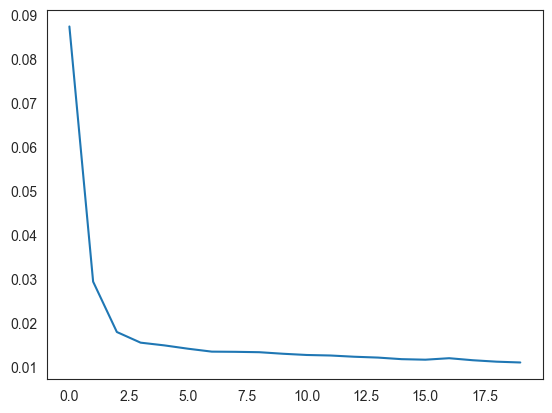

In [121]:
plt.plot(combined_diff_tracker)

### Evaluation

In [117]:
import seaborn as sns
def compute_expected_values(df, dynaq_agent):
    """
    Compute expected policy values for DynaQ agent, clinician actions, and random actions
    
    Args:
        df: DataFrame with state and action information
        dynaq_agent: Trained DynaQ agent
    Returns:
        tuple: (Q_RL, Q_clinician, Q_random) normalized values
    """
    Q_RL = 0
    Q_random = 0
    Q_clinician = 0
    num_patients = len(df['PatientID'].unique())
    
    # Process each patient at time 0
    for patient_id in df['PatientID'].unique():
        patient_data = df[df['PatientID'] == patient_id]
        initial_state = patient_data[patient_data['Timepoints'] == 0].iloc[0]
        
        # Get state index
        state_tuple = tuple(int(initial_state[col]) for col in binned_state_columns)
        try:
            state_idx = train_state_dict[state_tuple]
        except KeyError:
            state_idx = find_closest_index(state_tuple)
        
        # Get Q-values for the state
        q_values = dynaq_agent.q_table[state_idx]
        
        # Handle NaN values
        valid_q_values = q_values[~np.isnan(q_values)]
        if len(valid_q_values) > 0:
            max_q_value = np.max(valid_q_values)
            random_q_value = np.random.choice(valid_q_values)
            
            # Get clinician action Q-value
            clinician_action = int(initial_state['action_number'])
            clinician_q_value = q_values[clinician_action] if not np.isnan(q_values[clinician_action]) else np.mean(valid_q_values)
            
            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value
    
    # Normalize by number of patients
    Q_RL /= num_patients
    Q_clinician /= num_patients
    Q_random /= num_patients
    
    return Q_RL, Q_clinician, Q_random

def plot_expected_values(Q_RL, Q_clinician, Q_random, dataset_type='Train'):
    """
    Visualize expected policy values
    
    Args:
        Q_RL, Q_clinician, Q_random: Computed Q-values
        dataset_type: String indicating dataset type (Train/Test)
    """
    plt.figure(figsize=(5, 3))
    
    # Create DataFrame for seaborn
    data = pd.DataFrame({
        'Policy': ['DynaQ', 'Clinician', 'Random'],
        'Expected Value': [Q_RL, Q_clinician, Q_random]
    })
    
    # Plot with error bars
    sns.scatterplot(data=data, x='Policy', y='Expected Value', 
                palette=['#2ecc71', '#3498db', '#e74c3c'])
    
    plt.ylabel('Expected Policy Value')
    plt.title(f'[{dataset_type}] Expected Policy Value for each Patient (Timepoint = 0)')
    
    # Add value labels on top of bars
    for i, v in enumerate(data['Expected Value']):
        plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print numerical results
    print(f"\nExpected Policy Values ({dataset_type} Set):")
    print(f"DynaQ: {Q_RL:.4f}")
    print(f"Clinician: {Q_clinician:.4f}")
    print(f"Random: {Q_random:.4f}")
    
    # Calculate relative improvements
    print("\nRelative Improvements:")
    print(f"DynaQ vs Clinician: {((Q_RL/Q_clinician) - 1)*100:.2f}%")
    print(f"DynaQ vs Random: {((Q_RL/Q_random) - 1)*100:.2f}%")

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_87390/1912999125.py:70: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=data, x='Policy', y='Expected Value',


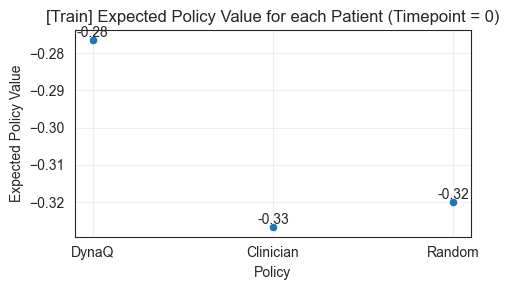


Expected Policy Values (Train Set):
DynaQ: -0.2764
Clinician: -0.3268
Random: -0.3199

Relative Improvements:
DynaQ vs Clinician: -15.41%
DynaQ vs Random: -13.60%


In [119]:
# Compute values for training set
sns.set_style("white")

Q_RL_train, Q_clinician_train, Q_random_train = compute_expected_values(
    df=train_mb_df,  
    dynaq_agent=trained_agent_2
)

# Plot training results
plot_expected_values(Q_RL_train, Q_clinician_train, Q_random_train, 'Train')

In [92]:
def compute_wis_for_dynaq(df, dynaq_agent, gamma=0.99):
    """
    Compute WIS estimates for DynaQ agent with handling of unseen states.
    
    Args:
        df: DataFrame with state, action, reward information
        dynaq_agent: OptimizedDynaQAgent instance
        gamma: Discount factor
    Returns:
        tuple: (avg_clinician_rewards, avg_policy_rewards, clinician_rewards, policy_rewards)
    """
    clinician_rewards = []
    policy_rewards = []
    
    # Get Q-table from agent
    q_table = dynaq_agent.q_table
    
    # Track unseen states
    unseen_states_count = 0
    total_states_count = 0
    
    unique_patients = df['PatientID'].unique()
    
    for patient_id in tqdm(unique_patients, desc="Processing patients"):
        patient_clinician_reward = 0
        patient_policy_reward = 0
        
        patient_df = df[df['PatientID'] == patient_id].sort_values('Timepoints').reset_index(drop=True)
        
        for i in range(len(patient_df) - 1):  # -1 to avoid last timepoint
            row = patient_df.iloc[i]
            timepoint = row['Timepoints']
            
            # Skip last timepoints
            if timepoint in [47, 48]:
                continue
                
            reward = row["reward"]
            action = int(row["action_number"])
            total_states_count += 1
            
            # Create state tuple with integer values
            state_tuple = tuple(int(row[col]) for col in binned_state_columns)
            
            # Try to get state index, if not found use closest state
            try:
                state = train_state_dict[state_tuple]
            except KeyError:
                unseen_states_count += 1
                state = find_closest_index(state_tuple)
            
            # Get policy probabilities
            q_values = q_table[state, :]
            
            # Handle NaN values
            valid_mask = ~np.isnan(q_values)
            if np.any(valid_mask):
                valid_q_values = q_values[valid_mask]
                exp_q = np.exp(valid_q_values - np.max(valid_q_values))
                probs = exp_q / exp_q.sum()
                policy_probs = np.zeros_like(q_values)
                policy_probs[valid_mask] = probs
            else:
                # If all values are NaN, use uniform distribution
                policy_probs = np.ones_like(q_values) / len(q_values)
            
            # Get policy probability for the action taken
            policy_action_prob = policy_probs[action]
            
            # Clinician action probability (assumed to be 0.95)
            clinician_action_prob = 0.95
            
            # Compute importance weight
            importance_weight = policy_action_prob / clinician_action_prob
            wis_estimate = importance_weight * reward
            
            # Accumulate discounted rewards
            patient_clinician_reward += (gamma ** timepoint) * reward
            patient_policy_reward += (gamma ** timepoint) * wis_estimate
        
        clinician_rewards.append(patient_clinician_reward)
        policy_rewards.append(patient_policy_reward)
    
    # Calculate averages
    avg_clinician_rewards = np.mean(clinician_rewards)
    avg_policy_rewards = np.mean(policy_rewards)
    
    # Print summary statistics
    print("\nWIS Evaluation Results:")
    print(f"Average Clinician Reward: {avg_clinician_rewards:.2f}")
    print(f"Average Policy Reward: {avg_policy_rewards:.2f}")
    print(f"Number of trajectories evaluated: {len(unique_patients)}")
    print(f"Unseen states: {unseen_states_count}/{total_states_count} ({unseen_states_count/total_states_count*100:.2f}%)")
    
    # Additional statistics
    print("\nDetailed Statistics:")
    print(f"Clinician Rewards - Mean: {np.mean(clinician_rewards):.2f}, Std: {np.std(clinician_rewards):.2f}")
    print(f"Policy Rewards - Mean: {np.mean(policy_rewards):.2f}, Std: {np.std(policy_rewards):.2f}")
    
    return avg_clinician_rewards, avg_policy_rewards, clinician_rewards, policy_rewards

Processing patients: 100%|██████████| 782/782 [00:40<00:00, 19.31it/s]



WIS Evaluation Results:
Average Clinician Reward: -3.18
Average Policy Reward: -1.23
Number of trajectories evaluated: 782
Unseen states: 1125/36754 (3.06%)

Detailed Statistics:
Clinician Rewards - Mean: -3.18, Std: 1.79
Policy Rewards - Mean: -1.23, Std: 1.04


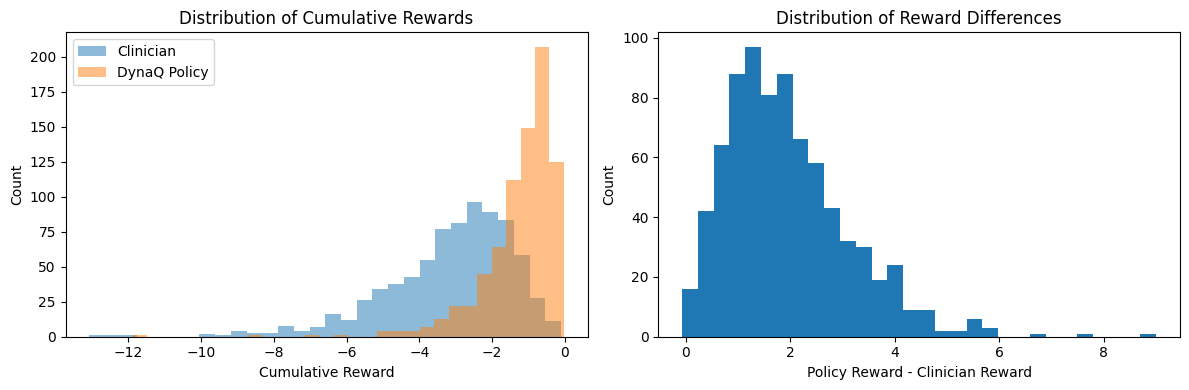

In [94]:
# Calculate WIS rewards
avg_clinician, avg_policy, clinician_rewards, policy_rewards = compute_wis_for_dynaq(
    df=test_mb_df,
    dynaq_agent=trained_agent_2,
    gamma=0.99
)

# Visualize distributions
plt.figure(figsize=(12, 4))

# Create subplot for rewards
plt.subplot(1, 2, 1)
plt.hist(clinician_rewards, alpha=0.5, label='Clinician', bins=30)
plt.hist(policy_rewards, alpha=0.5, label='DynaQ Policy', bins=30)
plt.xlabel('Cumulative Reward')
plt.ylabel('Count')
plt.title('Distribution of Cumulative Rewards')
plt.legend()

# Create subplot for reward differences
plt.subplot(1, 2, 2)
reward_diffs = np.array(policy_rewards) - np.array(clinician_rewards)
plt.hist(reward_diffs, bins=30)
plt.xlabel('Policy Reward - Clinician Reward')
plt.ylabel('Count')
plt.title('Distribution of Reward Differences')

plt.tight_layout()
plt.show()

In [95]:
# Calculate confidence intervals
from scipy import stats

def calculate_confidence_interval(data, confidence=0.95):
    return stats.t.interval(confidence, len(data)-1, loc=np.mean(data), scale=stats.sem(data))

clinician_ci = calculate_confidence_interval(clinician_rewards)
policy_ci = calculate_confidence_interval(policy_rewards)

print("\nConfidence Intervals (95%):")
print(f"Clinician: [{clinician_ci[0]:.2f}, {clinician_ci[1]:.2f}]")
print(f"Policy: [{policy_ci[0]:.2f}, {policy_ci[1]:.2f}]")


Confidence Intervals (95%):
Clinician: [-3.30, -3.05]
Policy: [-1.31, -1.16]


In [97]:
def get_policy_actions_dynaq(agent, df):
    """
    Get the actions predicted by the DynaQ policy
    
    Args:
        agent: OptimizedDynaQAgent instance
        df: DataFrame with state information
    Returns:
        numpy array of predicted actions
    """
    policy_actions = []
    unseen_states_count = 0
    total_states = 0
    
    for _, row in df.iterrows():
        total_states += 1
        # Create state tuple with integer values
        state_tuple = tuple(int(row[col]) for col in binned_state_columns)
        
        # Try to get state index, if not found use closest state
        try:
            state_idx = train_state_dict[state_tuple]
        except KeyError:
            unseen_states_count += 1
            state_idx = find_closest_index(state_tuple)
        
        q_values = agent.q_table[state_idx]
        
        # Handle NaN values
        if np.all(np.isnan(q_values)):
            # If all values are NaN, choose random action
            policy_actions.append(np.random.randint(0, agent.action_size))
        else:
            # Use nanargmax to handle NaN values
            policy_actions.append(np.nanargmax(q_values))
    
    print(f"Unseen states: {unseen_states_count}/{total_states} ({unseen_states_count/total_states*100:.2f}%)")
    return np.array(policy_actions)

def action_alignment_dynaq(agent, df):
    """
    Calculate action alignment for DynaQ agent
    
    Args:
        agent: OptimizedDynaQAgent instance
        df: DataFrame with state and action information
    Returns:
        float: alignment percentage
    """
    # Get clinician actions and policy actions
    clinician_actions = df['action_number'].values.astype(int)
    policy_actions = get_policy_actions_dynaq(agent, df)
    
    # Calculate alignment
    alignment = (policy_actions == clinician_actions).mean() * 100
    
    print("\nAction Alignment Results:")
    print(f"Total states evaluated: {len(clinician_actions)}")
    print(f"Alignment percentage: {alignment:.2f}%")
    
    return alignment

def detailed_action_alignment_dynaq(agent, df):
    """
    Calculate detailed action alignment statistics for DynaQ agent
    
    Args:
        agent: OptimizedDynaQAgent instance
        df: DataFrame with state and action information
    Returns:
        dict: Dictionary containing detailed alignment statistics
    """
    # Get clinician actions and policy actions
    clinician_actions = df['action_number'].values.astype(int)
    policy_actions = get_policy_actions_dynaq(agent, df)
    
    # Overall alignment
    overall_alignment = (policy_actions == clinician_actions).mean() * 100
    
    # Per-action alignment
    action_specific_alignment = {}
    action_counts = {}
    for action in range(agent.action_size):
        action_mask = clinician_actions == action
        if np.any(action_mask):
            alignment = (policy_actions[action_mask] == clinician_actions[action_mask]).mean() * 100
            count = np.sum(action_mask)
            action_specific_alignment[action] = alignment
            action_counts[action] = count
    
    # Per-patient alignment
    patient_alignments = {}
    for patient_id in df['PatientID'].unique():
        patient_mask = df['PatientID'] == patient_id
        patient_clinician = clinician_actions[patient_mask]
        patient_policy = policy_actions[patient_mask]
        alignment = (patient_policy == patient_clinician).mean() * 100
        patient_alignments[patient_id] = alignment
    
    # Compile statistics
    stats = {
        'overall_alignment': overall_alignment,
        'per_action_alignment': action_specific_alignment,
        'action_counts': action_counts,
        'per_patient_alignment': patient_alignments,
        'mean_patient_alignment': np.mean(list(patient_alignments.values())),
        'std_patient_alignment': np.std(list(patient_alignments.values())),
        'total_states': len(clinician_actions),
        'total_patients': len(patient_alignments)
    }
    
    # Print summary
    print("\nDetailed Action Alignment Results:")
    print(f"Overall alignment: {stats['overall_alignment']:.2f}%")
    print(f"Mean patient alignment: {stats['mean_patient_alignment']:.2f}%")
    print(f"Patient alignment std: {stats['std_patient_alignment']:.2f}%")
    print("\nPer-action alignment:")
    for action in range(agent.action_size):
        if action in action_specific_alignment:
            print(f"Action {action}: {action_specific_alignment[action]:.2f}% "
                  f"(n={action_counts[action]})")
    
    return stats

In [108]:
# Calculate basic alignment
alignment = action_alignment_dynaq(
    agent=trained_agent_2,
    df=test_mb_df
)
# Get detailed alignment statistics
detailed_stats = detailed_action_alignment_dynaq(
    agent=trained_agent_2,
    df=test_mb_df
)

Unseen states: 1142/37536 (3.04%)

Action Alignment Results:
Total states evaluated: 37536
Alignment percentage: 21.48%
Unseen states: 1142/37536 (3.04%)

Detailed Action Alignment Results:
Overall alignment: 21.48%
Mean patient alignment: 21.48%
Patient alignment std: 13.73%

Per-action alignment:
Action 0: 21.38% (n=30992)
Action 1: 22.67% (n=2903)
Action 2: 22.31% (n=1291)
Action 3: 28.01% (n=1314)
Action 4: 14.13% (n=92)
Action 5: 12.50% (n=8)
Action 6: 0.00% (n=2)
Action 7: 20.00% (n=15)
Action 8: 14.47% (n=477)
Action 9: 0.00% (n=56)
Action 10: 5.26% (n=19)
Action 11: 0.00% (n=4)
Action 12: 11.42% (n=289)
Action 13: 2.56% (n=39)
Action 14: 6.25% (n=16)
Action 15: 5.26% (n=19)


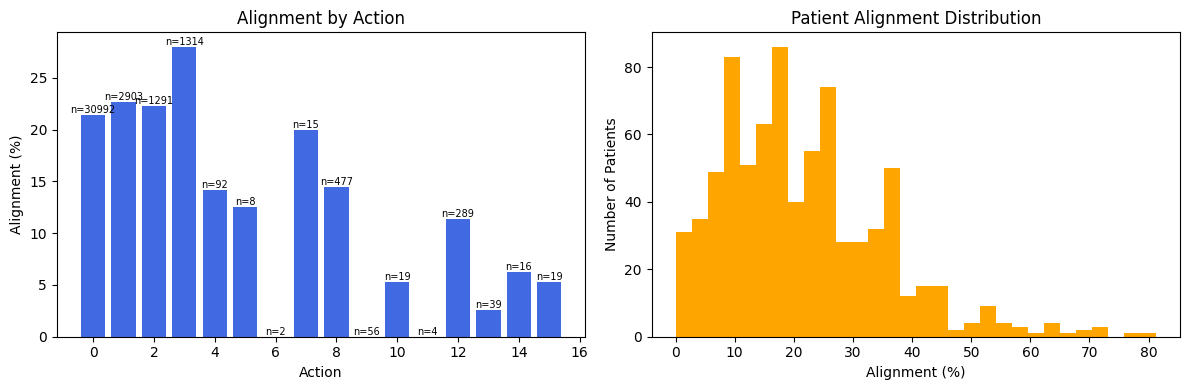

In [109]:
# Visualize results
# Plot per-action alignment
plt.figure(figsize=(12, 4))

# Action-specific alignment
plt.subplot(1, 2, 1)
actions = list(detailed_stats['per_action_alignment'].keys())
alignments = list(detailed_stats['per_action_alignment'].values())
counts = [detailed_stats['action_counts'][a] for a in actions]

plt.bar(actions, alignments, color="royalblue")
plt.xlabel('Action')
plt.ylabel('Alignment (%)')
plt.title('Alignment by Action')

# Add count labels
for i, count in enumerate(counts):
    plt.text(actions[i], alignments[i], f'n={count}', 
             ha='center', va='bottom', fontsize=7)

# Patient alignment distribution
plt.subplot(1, 2, 2)
plt.hist(list(detailed_stats['per_patient_alignment'].values()), bins=30, color="orange")
plt.xlabel('Alignment (%)')
plt.ylabel('Number of Patients')
plt.title('Patient Alignment Distribution')

plt.tight_layout()
plt.show()

In [131]:
import seaborn as sns

fluid_boluses_dict = {
    **dict.fromkeys([0, 1, 2, 3], '[0, 250)'),
    **dict.fromkeys([4, 5, 6, 7], '[250, 500)'),
    **dict.fromkeys([8, 9, 10, 11], '[500, 1000)'),
    **dict.fromkeys([12, 13, 14, 15], '>= 1000')
}
vasopressors_dict = {
    **dict.fromkeys([0, 4, 8, 12], '0'),
    **dict.fromkeys([1, 5, 9, 13], '(0, 8.4)'),
    **dict.fromkeys([2, 6, 10, 14], '[8.4, 20.28)'),
    **dict.fromkeys([3, 7, 11, 15], '>= 20.28')
}

def decode_action(action):
    fluid = fluid_boluses_dict[action]
    vasopressor = vasopressors_dict[action]
    return fluid, vasopressor

def get_action_distribution_dynaq(agent, df):
    """
    Compute the decoded action distribution for DynaQ agent.
    
    Args:
        agent: OptimizedDynaQAgent instance
        df: DataFrame with state information
    Returns:
        numpy array: Action distribution matrix
    """
    # Initialize count matrix
    fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']
    vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']
    action_count_matrix = np.zeros((len(vasopressor_categories), len(fluid_categories)))
    
    unseen_states_count = 0
    total_states = 0
    
    # Get predicted actions for each state
    for _, row in df.iterrows():
        total_states += 1
        # Create state tuple with integer values
        state_tuple = tuple(int(row[col]) for col in binned_state_columns)
        
        # Try to get state index, if not found use closest state
        try:
            state_idx = train_state_dict[state_tuple]
        except KeyError:
            unseen_states_count += 1
            state_idx = find_closest_index(state_tuple)
        
        # Get Q-values and predicted action
        q_values = agent.q_table[state_idx]
        
        if np.all(np.isnan(q_values)):
            # Skip if all Q-values are NaN
            continue
        else:
            action = np.nanargmax(q_values)
            
            # Decode and count the action
            fluid, vasopressor = decode_action(action)
            fluid_idx = fluid_categories.index(fluid)
            vasopressor_idx = vasopressor_categories.index(vasopressor)
            action_count_matrix[vasopressor_idx, fluid_idx] += 1
    
    # Normalize to get probability distribution
    total_valid_actions = np.sum(action_count_matrix)
    if total_valid_actions > 0:
        action_distribution = action_count_matrix / total_valid_actions
    else:
        action_distribution = action_count_matrix
    
    print(f"\nAction Distribution Statistics:")
    print(f"Total states processed: {total_states}")
    print(f"Unseen states: {unseen_states_count}/{total_states} ({unseen_states_count/total_states*100:.2f}%)")
    print(f"Valid actions: {total_valid_actions}")
    
    return action_distribution

def get_clinician_action_distribution(clinician_actions):
    """Compute the decoded action distribution for clinician actions."""
    # Initialize count matrix
    fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']  # Sorted fluid boluses
    vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']  # Sorted vasopressors
    action_count_matrix = np.zeros((len(vasopressor_categories), len(fluid_categories)))

    # Count the occurrences of each fluid-vasopressor combination
    for action in clinician_actions:
        fluid, vasopressor = decode_action(action)  # Use the same decode_action function
        fluid_idx = fluid_categories.index(fluid)
        vasopressor_idx = vasopressor_categories.index(vasopressor)
        action_count_matrix[vasopressor_idx, fluid_idx] += 1

    # Normalize to get a probability distribution
    action_distribution = action_count_matrix / len(clinician_actions)
    return action_distribution

def plot_action_distributions(distributions_dict):
    """
    Plot heatmaps of action distributions for different agents.
    
    Args:
        distributions_dict: Dictionary mapping agent names to their action distributions
    """
    fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']
    vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']
    
    n_distributions = len(distributions_dict)
    fig, axes = plt.subplots(1, n_distributions, figsize=(4*n_distributions, 3))
    
    if n_distributions == 1:
        axes = [axes]
    
    for i, (ax, (name, dist)) in enumerate(zip(axes, distributions_dict.items())):
        sns.heatmap(dist, annot=True, fmt='.2f', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'{name} Action Distribution', size=10)
        ax.set_xlabel('Fluid Boluses', size=9)
        ax.set_ylabel('Vasopressors', size=9)
        ax.set_xticklabels(fluid_categories, size=7, rotation=0)
        ax.set_yticklabels(vasopressor_categories, size=7)
        if i == 0:
            ax.set_ylabel("Vasopressors", size=9)
        else:
            ax.set_ylabel("")
    
    plt.tight_layout()
    plt.show()


Action Distribution Statistics:
Total states processed: 37536
Unseen states: 1142/37536 (3.04%)
Valid actions: 37536.0


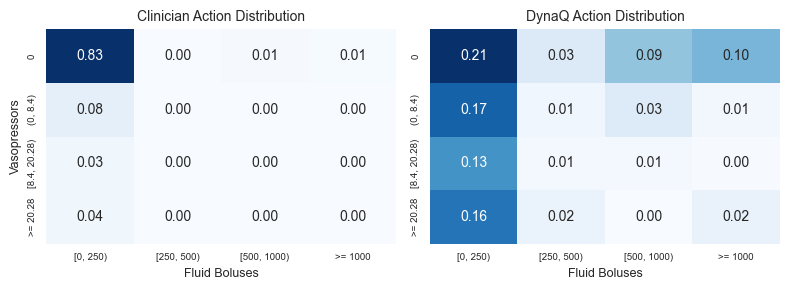

In [132]:
# Get action distributions
action_distribution_clinician = get_clinician_action_distribution(test_mb_df['action_number'].values)
action_distribution_dynaq = get_action_distribution_dynaq(trained_agent_2, test_mb_df)

# Plot distributions
distributions = {
    'Clinician': action_distribution_clinician,
    'DynaQ': action_distribution_dynaq
}
plot_action_distributions(distributions)

In [137]:
def get_policy_actions_dynaq(agent, df):
    """
    Get predicted actions from DynaQ agent
    
    Args:
        agent: OptimizedDynaQAgent instance
        df: DataFrame with state information
    Returns:
        tuple: Arrays of predicted fluid and vasopressor actions
    """
    predicted_actions = []
    unseen_states_count = 0
    total_states = 0
    
    for _, row in df.iterrows():
        total_states += 1
        # Create state tuple with integer values
        state_tuple = tuple(int(row[col]) for col in binned_state_columns)
        
        # Try to get state index, if not found use closest state
        try:
            state_idx = train_state_dict[state_tuple]
        except KeyError:
            unseen_states_count += 1
            state_idx = find_closest_index(state_tuple)
        
        # Get Q-values and predicted action
        q_values = agent.q_table[state_idx]
        
        if np.all(np.isnan(q_values)):
            # If all values are NaN, choose random action
            predicted_actions.append(np.random.randint(0, agent.action_size))
        else:
            # Use nanargmax to handle NaN values
            predicted_actions.append(np.nanargmax(q_values))
    
    print(f"Unseen states: {unseen_states_count}/{total_states} ({unseen_states_count/total_states*100:.2f}%)")
    
    # Decode actions into fluid and vasopressor components
    fluids, vasopressors = zip(*[decode_action(action) for action in predicted_actions])
    return np.array(fluids), np.array(vasopressors)

In [135]:
# apply MAP tier
def categorize_map(row):
    if row.MAP ==3:
        return ">65"
    elif row.MAP == 2:
        return "60-65"
    elif row.MAP == 1:
        return "55-60"
    else:
        return "<55"

# Apply this to the dataset
test_mb_df_2 = test_mb_df.copy()
test_mb_df_2['MAP_tier'] = test_mb_df_2.apply(categorize_map, axis=1)

In [138]:
# Add DynaQ predictions to the test data
test_mb_df_2["dynaq_fluid"], test_mb_df_2["dynaq_vasopressor"] = get_policy_actions_dynaq(
    trained_agent_2, test_mb_df_2)

Unseen states: 1142/37536 (3.04%)


In [139]:
def get_action_proportions(df, policy_name):
    """Calculate action proportions for a given policy by MAP tier"""
    # Group by MAP tier and actions
    action_counts = df.groupby([
        "MAP_tier", 
        f"{policy_name}_fluid", 
        f"{policy_name}_vasopressor"
    ]).size().reset_index(name="count")
    
    # Convert to categorical with ordered categories
    action_counts['MAP_tier'] = pd.Categorical(
        action_counts['MAP_tier'], 
        categories=["<55", "55-60", "60-65", ">65"], 
        ordered=True
    )
    action_counts[f"{policy_name}_fluid"] = pd.Categorical(
        action_counts[f"{policy_name}_fluid"],
        categories=["[0, 250)", "[250, 500)", "[500, 1000)", ">= 1000"],
        ordered=True
    )
    action_counts[f"{policy_name}_vasopressor"] = pd.Categorical(
        action_counts[f"{policy_name}_vasopressor"],
        categories=["0", "(0, 8.4)", "[8.4, 20.28)", ">= 20.28"],
        ordered=True
    )
    
    # Calculate proportions for fluids and vasopressors
    fluid_props = action_counts.groupby(["MAP_tier", f"{policy_name}_fluid"])["count"].sum()\
        .groupby(level=0, group_keys=False).apply(lambda x: x / x.sum())\
        .reset_index(name='proportion')
    
    vaso_props = action_counts.groupby(["MAP_tier", f"{policy_name}_vasopressor"])["count"].sum()\
        .groupby(level=0, group_keys=False).apply(lambda x: x / x.sum())\
        .reset_index(name='proportion')
    
    return fluid_props.rename(columns={f"{policy_name}_fluid": "fluid"}),\
           vaso_props.rename(columns={f"{policy_name}_vasopressor": "vasopressor"})

In [140]:
# Get proportions
fluid_props, vaso_props = get_action_proportions(test_mb_df_2, "dynaq")

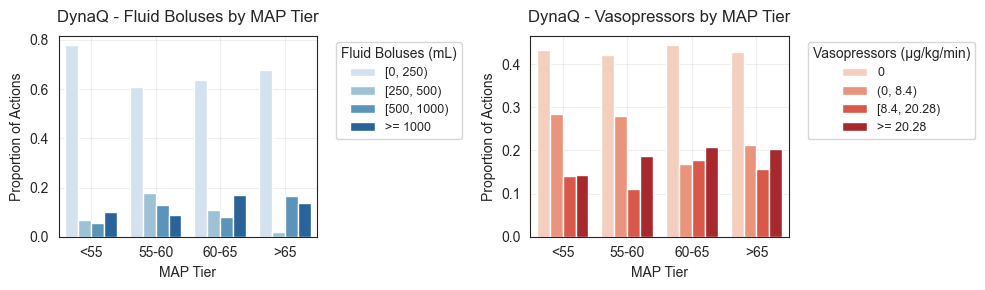

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))  # Increased figure width to accommodate legends
    
fluid_palette = sns.color_palette("Blues", n_colors=4)
vaso_palette = sns.color_palette("Reds", n_colors=4)
    
# Plot fluid boluses
sns.barplot(data=fluid_props, x='MAP_tier', y='proportion', hue='fluid', palette=fluid_palette, ax=ax1)
    
ax1.set_title('DynaQ - Fluid Boluses by MAP Tier', fontsize=12, pad=10)
ax1.set_xlabel('MAP Tier', fontsize=10)
ax1.set_ylabel('Proportion of Actions', fontsize=10)
ax1.legend(title="Fluid Boluses (mL)", 
          title_fontsize=10, 
          fontsize=9,
          bbox_to_anchor=(1.05, 1),
          loc='upper left')
ax1.grid(True, alpha=0.3)
    
# Plot vasopressors
sns.barplot(data=vaso_props, x='MAP_tier', y='proportion', hue='vasopressor', palette=vaso_palette, ax=ax2)
    
ax2.set_title('DynaQ - Vasopressors by MAP Tier', fontsize=12, pad=10)
ax2.set_xlabel('MAP Tier', fontsize=10)
ax2.set_ylabel('Proportion of Actions', fontsize=10)
ax2.legend(title="Vasopressors (μg/kg/min)", 
          title_fontsize=10, 
          fontsize=9,
          bbox_to_anchor=(1.05, 1),
          loc='upper left')
ax2.grid(True, alpha=0.3)
    
# Add summary statistics as text
def add_stats_text(ax, props, title):
    stats_text = f"{title} Distribution:\n"
    for category in props['fluid' if 'fluid' in props.columns else 'vasopressor'].unique():
        mean_prop = props[props['fluid' if 'fluid' in props.columns else 'vasopressor'] == category]['proportion'].mean()
        stats_text += f"{category}: {mean_prop:.3f}\n"
    ax.text(1.45, 0.5, stats_text, transform=ax.transAxes,  # Moved text further right
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
            fontsize=9, verticalalignment='center')
    
#add_stats_text(ax1, fluid_props, "Overall Fluid")
#add_stats_text(ax2, vaso_props, "Overall Vasopressor")
    
plt.tight_layout()
plt.show()